This notebook contains code to reproduce the figures appearing in Nicolas & Boos, "A theory for the response of tropical moist convection to mechanical orographic forcing". It is meant to be run with Python3, using the packages imported below. It is divided into sections defined by Markdown titles; each section is standalone (e.g. you don't need to run section 1 before running section 2), and each produces one plot.

In [1]:
# Required packages
import numpy as np
import xarray as xr

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import to_rgb
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from scipy.ndimage import gaussian_filter

In [2]:
#Custom functions
from orographicConvectionTheory import linear_TdL_qdL,linear_precip_theory,analytical_precip_agnesi,nonlinear_precip_theory,topographic_profile, smith_theory

In [3]:
pT_ov_g=8000
cp=1004.
Lc=2.5e6
g=9.81

hrhgt = xr.open_dataarray("data/wrf.100x2.mountain.3km.HGT.nc")       #WRF topographic height, h0=1000m
lmhgt = xr.open_dataarray("data/wrf.100x2.mountain.500m.3km.HGT.nc")  #WRF topographic height, h0=500m
hrdist=(1635-hrhgt.west_east)*3

def hatprime(var,idx1,idx2):
    """Vertically average variable between two pressure levels indicated by their indices (idx1 and idx2), and take deviation from upstream value"""
    varhat = var[idx1:idx2].integrate('pressure')/(var.pressure[idx2]-var.pressure[idx1])
    return varhat - varhat[2200:2400].mean('distance_from_mtn')


# Figure 1 - TRMM climatology & cross-section

In [4]:
# TRMM precip, 1998-2013 seasonal average
pr_gpm_mnthmean = xr.open_dataarray("data/pr.GPM-IMERG.3B-MO.MS.MRG.3IMERG.seasonalmean.nc")
pr_gpm_plot_jja=pr_gpm_mnthmean.sel(month=[6,7,8]).mean('month')
pr_gpm_plot_ond=pr_gpm_mnthmean.sel(month=[10,11,12]).mean('month')

In [5]:
# ERA5 OROGRAPHY
orog1 = xr.open_dataset("data/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc")
orog=orog1.Z.isel(time=0)/9.80665
orog_plot = orog.reindex(latitude=list(reversed(orog.latitude))).sel(latitude=slice(-30,30))
orog_plot.coords['longitude'] = (orog_plot.coords['longitude'] + 180) % 360 -180
orog_plot = orog_plot.sortby(orog_plot.longitude)
# Apply Gaussian smooth ing
orog_plot_smooth=xr.apply_ufunc(gaussian_filter,orog_plot  ,kwargs={"sigma":1.5})

In [6]:
# ERA5 100m wind, 1998-2013 seasonal average
era5100u = xr.open_dataarray("data/e5.oper.an.sfc.228_246_100u.ll025sc.1998010100_2014010100.seasonalmean.nc")
era5100v = xr.open_dataarray("data/e5.oper.an.sfc.228_247_100v.ll025sc.1998010100_2014010100.seasonalmean.nc")

u100plot=era5100u.sel(latitude=slice(30,-30))
v100plot=era5100v.sel(latitude=slice(30,-30))

u100plot.coords['longitude'] = (u100plot.coords['longitude'] + 180) % 360 -180
u100plot = u100plot.sortby(u100plot.longitude)
v100plot.coords['longitude'] = (v100plot.coords['longitude'] + 180) % 360 -180
v100plot = v100plot.sortby(v100plot.longitude)

u100plot_jja = u100plot.sel(month=[6,7,8]).mean('month')
v100plot_jja = v100plot.sel(month=[6,7,8]).mean('month')

u100plot_ond = u100plot.sel(month=[10,11,12]).mean('month')
v100plot_ond = v100plot.sel(month=[10,11,12]).mean('month')

In [7]:
def cross_section(prjja,prond,orog,lon1,lon2,lat,ax):
    """Plot a cross section of orography, JJA and OND precip at a given latitude and between two given longitudes """
    ax2=ax.twinx()
    prjja.sel(longitude=slice(lon1,lon2)).sel(latitude=lat,method='nearest').plot(ax=ax2,color='g',label='JJA precipitation',linewidth=3)#
    prond.sel(longitude=slice(lon1,lon2)).sel(latitude=lat,method='nearest').plot(ax=ax2,color='dodgerblue',label='OND precipitation',linewidth=3)#
    orog.sel(longitude=slice(lon1,lon2)).sel(latitude=lat,method='nearest').plot(ax=ax,color='k',label='Surface elevation',linewidth=3)#
    
    ax.set_xlabel('')
    ax.set_ylabel('Z (m)')
    ax.set_xlim((lon1,lon2))
    ticklon=range(lon1,lon2,10)[1:]
    ax.set_xticks(ticklon)
    ax.set_xticklabels(["%i°E"%t for t in ticklon])
    ax.set_title('')
    ax2.set_title('')
    
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    
    return ax2


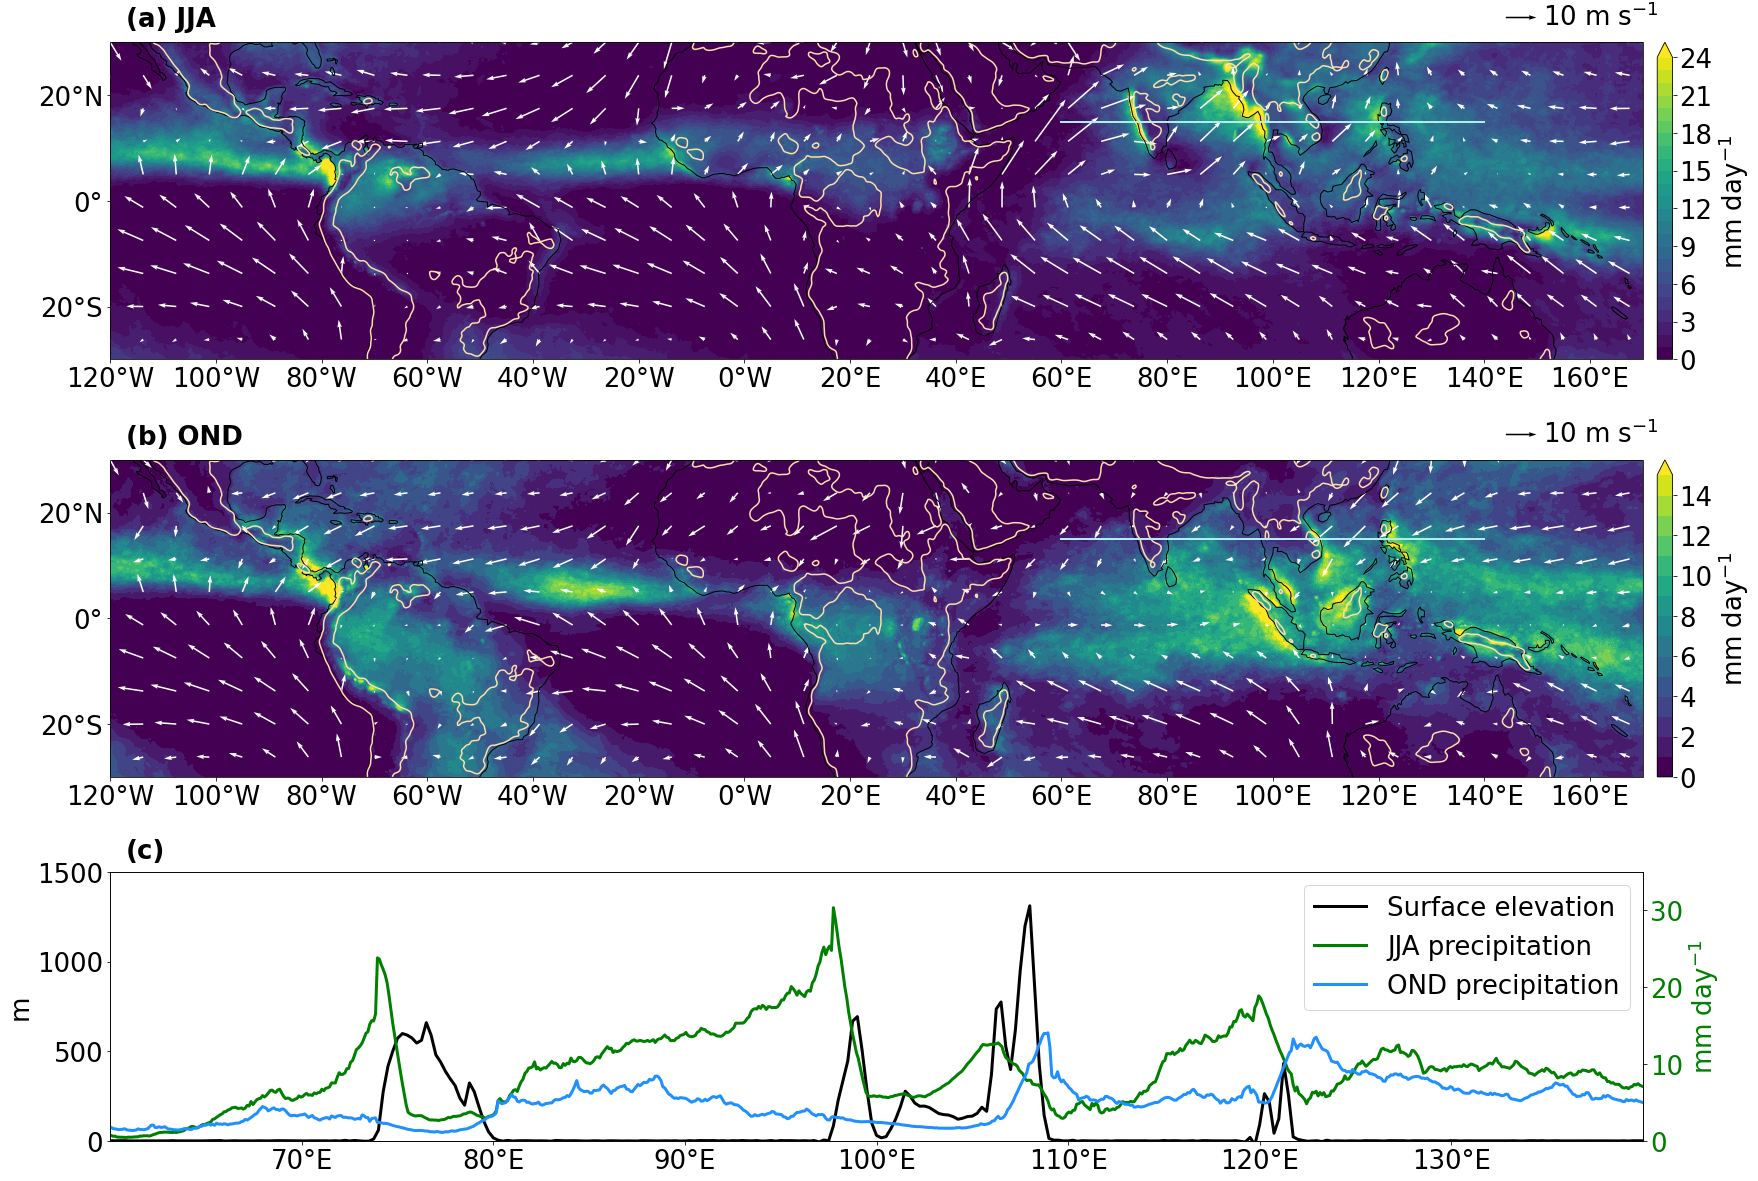

In [8]:
matplotlib.rcParams.update({'font.size': 26})
fig = plt.figure(figsize=(25,17))
spec = gridspec.GridSpec(ncols=1, nrows=3, height_ratios= [5,5,4.1],figure=fig)
ax = fig.add_subplot(spec[0],projection= ccrs.PlateCarree())
ax1 = fig.add_subplot(spec[1],projection= ccrs.PlateCarree())
ax2 = fig.add_subplot(spec[2])

#Precipitation shadings
cf =pr_gpm_plot_jja.sel(longitude=slice(-120,170)).plot.contourf(ax=ax,levels=np.arange(0.,25.,1.),add_colorbar=False)
cf1=pr_gpm_plot_ond.sel(longitude=slice(-120,170)).plot.contourf(ax=ax1,levels=np.arange(0.,16.,1.),add_colorbar=False)

# Wind vectors, orography, colorbars
for a,c,uplot,vplot in (ax,cf,u100plot_jja,v100plot_jja),(ax1,cf1,u100plot_ond,v100plot_ond):
    #orography
    orog_plot_smooth.sel(longitude=slice(-120,170)).plot.contour(ax=a,levels=[500.],colors='navajowhite',linewidths=[1.5])
    
    #wind vectors
    u=uplot.sel(longitude=slice(-120,170))
    v=vplot.sel(longitude=slice(-120,170))
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = u.longitude.expand_dims({"latitude":u.latitude})
    n=25
    m=n
    Q = a.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m], transform=ccrs.PlateCarree(),color="w",width=0.001,scale=500)

    #Latitude line
    a.plot([60,140],[15,15],color='paleturquoise',linewidth=2)
    
    a.coastlines()
    a.set_ylim(-30,30)
    a.set_xlim(-120,170)
    a.set_title("")
    a.set_xticks(range(-120,170,20), crs=ccrs.PlateCarree())
    a.set_yticks(range(-20,30,20), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    a.xaxis.set_major_formatter(lon_formatter)
    a.yaxis.set_major_formatter(lat_formatter)
    a.set_xlabel("")
    a.set_ylabel("")
    
    # Colorbar
    pad=.2;size="1%"
    divider = make_axes_locatable(a)
    cax = divider.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
    plt.colorbar(c, cax=cax,label=r'mm day$^{-1}$')

    # Quiver key (reference wind arrow)
    qk = a.quiverkey(Q, 0.93, 1.08, 10, r'10 m s$^{-1}$', labelpos='E',
                       coordinates='axes',color='k')
    
#Cross-section (third panel)
ax3=cross_section(pr_gpm_plot_jja,pr_gpm_plot_ond,orog_plot,60,140,15,ax2)
#Make third panel the same width as panels a and b
for a in ax2,ax3:
    divider2 = make_axes_locatable(a)
    cax2 = divider2.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
    cax2.remove()
ax2.set_ylim(0,1500)
ax3.set_ylim(0,35)
ax2.set_ylabel("m")
ax3.tick_params(axis ='y', labelcolor = 'g')
ax3.set_ylabel(r'mm day$^{-1}$',color='g')

#Panel labels
ax.text(0.01, 1.05,'(a) JJA', transform=ax.transAxes,color='k',weight='bold')
ax1.text(0.01, 1.05,'(b) OND', transform=ax1.transAxes,color='k',weight='bold')
ax3.text(0.01, 1.05,'(c)', transform=ax3.transAxes,color='k',weight='bold')

fig.tight_layout()
#fig.savefig('figures/trmmOrog.png', dpi=300 ,bbox_inches='tight')

# Figure 2 - Theory precip

In [9]:
xx,hx = topographic_profile(kind='agnesi',a=50e3,A=1000)
P1000 = linear_precip_theory(xx,hx,10)
P500   = linear_precip_theory(xx,hx/2,10)
Ptau   = linear_precip_theory(xx,hx,10,tauT=4.5,tauq=16.5)
P1000_nodamp = linear_precip_theory(xx,hx,10,switch=1e-4)


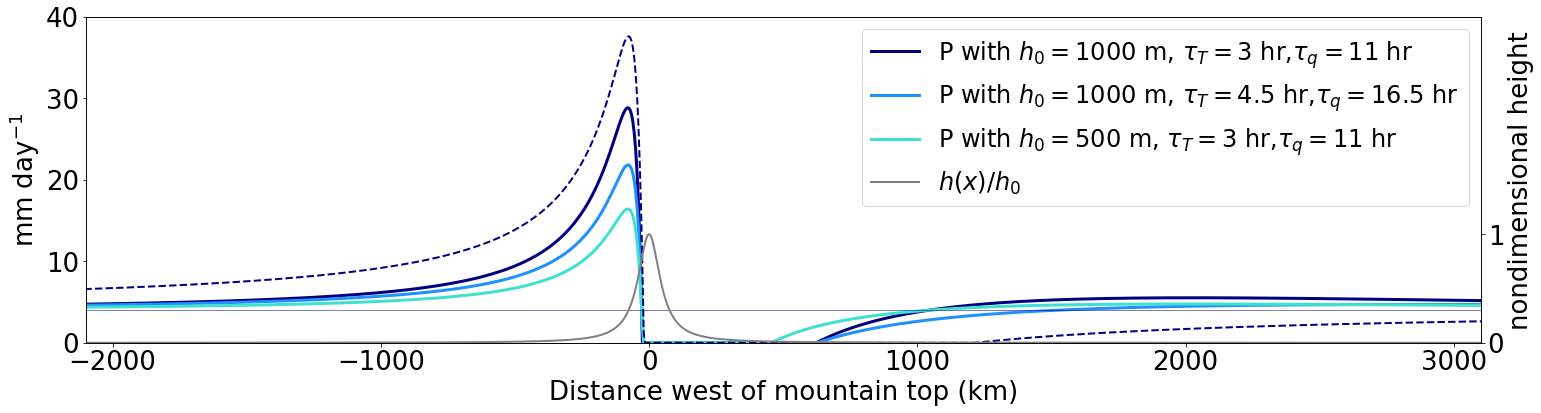

In [10]:
matplotlib.rcParams.update({'font.size': 26})
fig,ax=plt.subplots(1,1,figsize=(25,6))
ax2=ax.twinx()

# precips
ax.plot(xx/1000,P1000,label=r"P with $h_0=1000$ m, $\tau_T=3$ hr,$\tau_q=11$ hr"    ,color='navy',linewidth=3)
ax.plot(xx/1000,Ptau ,label=r"P with $h_0=1000$ m, $\tau_T=4.5$ hr,$\tau_q=16.5$ hr",color='dodgerblue',linewidth=3)
ax.plot(xx/1000,P500 ,label=r"P with $h_0=500$ m, $\tau_T=3$ hr,$\tau_q=11$ hr"     ,color='turquoise',linewidth=3)

ax.plot(xx/1000,P1000_nodamp,linestyle='--',color='navy',linewidth=2)

# mountain
ax2.plot(xx/1000,hx/1000,label=r"$h(x)/h_0$",color='gray',linewidth=2)

# Decoration
ax.axhline(4.,linewidth=0.5,color='navy')
ax.set_xlabel('Distance west of mountain top (km)')
ax.set_ylabel(r'mm day$^{-1}$')
ax.set_xlim(-2.1e3,3.1e3)
ax.set_ylim(0,40)

ax2.set_ylabel('nondimensional height')
ax2.set_ylim(0,3)
ax2.set_yticks([0,1])

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc=1,fontsize=24)
#fig.savefig('figures/analyticalAgnesi.eps',bbox_inches='tight')

# Figure 3 - WRF Precip & CAPE

In [4]:
hrpr  =xr.open_dataarray("data/wrf.100x2.mountain.3km.precip.days50-200.mean.nc")
lmpr  =xr.open_dataarray("data/wrf.100x2.mountain.500m.3km.precip.days50-200.mean.nc")
hrcape=xr.open_dataarray("data/wrf.100x2.mountain.3km.CAPE.days50-200.mean.nc")
lmcape=xr.open_dataarray("data/wrf.100x2.mountain.500m.3km.CAPE.days50-200.mean.nc")

hrpr_percentiles  =xr.open_dataarray("data/wrf.100x2.mountain.3km.precip.days50-200.percentiles.nc")
lmpr_percentiles  =xr.open_dataarray("data/wrf.100x2.mountain.500m.3km.precip.days50-200.percentiles.nc")
hrcape_percentiles=xr.open_dataarray("data/wrf.100x2.mountain.3km.CAPE.days50-200.percentiles.nc")
lmcape_percentiles=xr.open_dataarray("data/wrf.100x2.mountain.500m.3km.CAPE.days50-200.percentiles.nc")


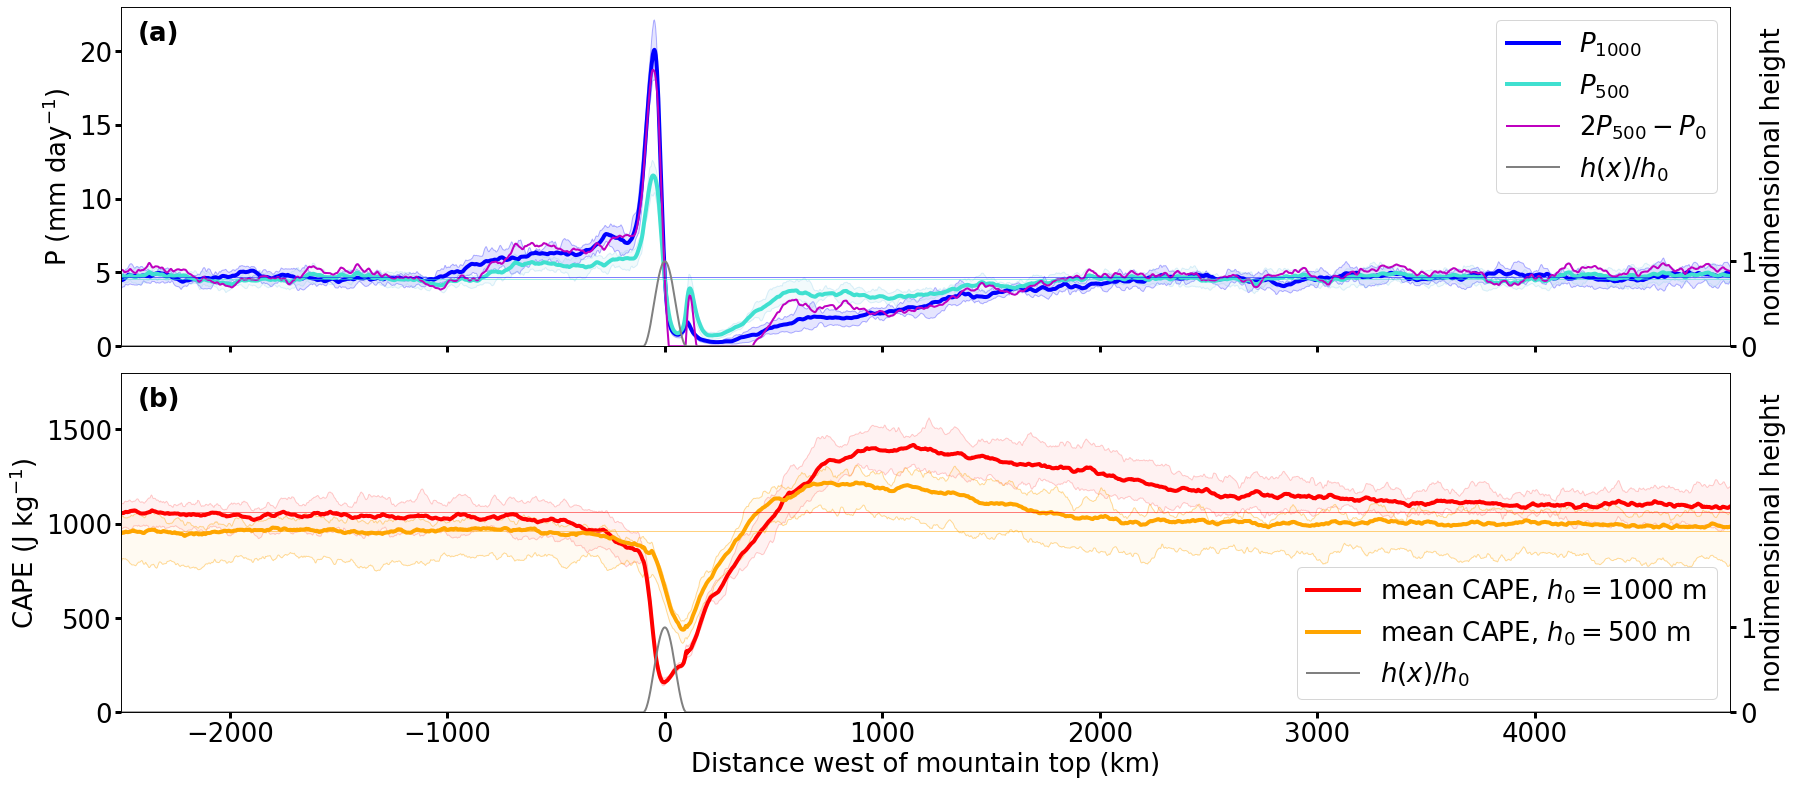

In [5]:
matplotlib.rcParams.update({'font.size': 26})

fig,(axpr,axca)=plt.subplots(2,1,figsize=(25,11))
axmt1=axpr.twinx()
axmt2=axca.twinx()

lw=2
lw2=4
falpha=0.1
ealpha=0.3

#PANEL 1 - Precip
#main precip curves
axpr.plot(hrdist,hrpr,label=r"$P_{1000}$",color='b',linewidth=lw2)
axpr.plot(hrdist,lmpr,label=r"$P_{500}$",color='turquoise',linewidth=lw2)
axpr.plot(hrdist,np.maximum(0.,2*(lmpr-4.4)+4.4),label=r"$2P_{500}-P_0$",color='m',linewidth=lw)
#shading
axpr.fill_between(hrdist,hrpr_percentiles.sel(percentile=25),hrpr_percentiles.sel(percentile=75),facecolor=(0,0,1,falpha), edgecolor=(0,0,1,ealpha))
axpr.fill_between(hrdist,lmpr_percentiles.sel(percentile=25),lmpr_percentiles.sel(percentile=75),facecolor=(*to_rgb('skyblue'),falpha), edgecolor=(*to_rgb('skyblue'),ealpha))
#P_0
axpr.axhline(hrpr[2000:3000].mean(),color='b',linestyle='-',linewidth=.5)
axpr.axhline(lmpr[2000:3000].mean(),color='turquoise',linestyle='-',linewidth=.5)

axpr.set_ylim(0,23)
axpr.set_ylabel(r'P (mm day$^{-1}$)')


#PANEL 2 - CAPE
# main CAPE curves
axca.plot(hrdist,hrcape,label=r"mean CAPE, $h_0=1000$ m",color='r',linewidth=lw2)
axca.plot(hrdist,lmcape,label=r"mean CAPE, $h_0=500$ m",color='orange',linewidth=lw2)
#shading
falpha=0.05;ealpha=0.2
axca.fill_between(hrdist,hrcape_percentiles.sel(percentile=25),hrcape_percentiles.sel(percentile=75),facecolor=(1.,0,0,falpha), edgecolor=(1.,0,0,ealpha))
falpha=0.05;ealpha=0.4
axca.fill_between(hrdist,lmcape_percentiles.sel(percentile=25),lmcape_percentiles.sel(percentile=75),facecolor=(*to_rgb('orange'),falpha), edgecolor=(*to_rgb('orange'),ealpha))
#CAPE_0
axca.axhline(hrcape[2000:3000].mean(),color='r',linestyle='-',linewidth=0.5)
axca.axhline(lmcape[2000:3000].mean(),color='orange',linestyle='-',linewidth=0.5)

axca.set_ylim(0,1800)
axca.set_xlabel("Distance west of mountain top (km)")
axca.set_ylabel(r"CAPE (J kg$^{-1}$)")

#Mountains & decoration
for a,am,loc,txt in ((axpr,axmt1,0,'(a)'),(axca,axmt2,4,'(b)')):
    am.plot(hrdist,hrhgt/1000,color='gray',label=r'$h(x)/h_0$',linewidth=2)
    am.set_xlim(-2500,4900)
    am.set_ylim(0,4)
    am.set_ylabel('nondimensional height')
    am.set_yticks([0,1])
    
    lines,labels = a.get_legend_handles_labels()
    lines2,labels2 = am.get_legend_handles_labels()
    a.legend(lines + lines2, labels + labels2, loc=loc)
    a.text(0.01, 0.9,txt, transform=a.transAxes,color='k',weight='bold')

    a.tick_params(width=3,length=6)
    am.tick_params(width=3,length=6)
    
    if txt!='(b)': # Get rid of x ticks on top panel
        ticks=range(-2000,5000,1000)
        a.set_xticks(ticks)
        a.set_xticklabels([""]*len(ticks))

fig.tight_layout(pad=0.4)
#fig.savefig('figures/wrfPCape.png', dpi=300 ,bbox_inches='tight')

# Figure 4 - x-z cross sections of vertical motion, from moist & dry simulations

In [4]:
wmean_p    = xr.open_dataarray("data/wrf.100x2.mountain.3km.W_PL.days50-200.mean.nc")     # control simulation
wdrymean_p = xr.open_dataarray("data/wrf.100x2.mountain.dry.3km.W_PL.days50-100.mean.nc") # Lv=0 simulation

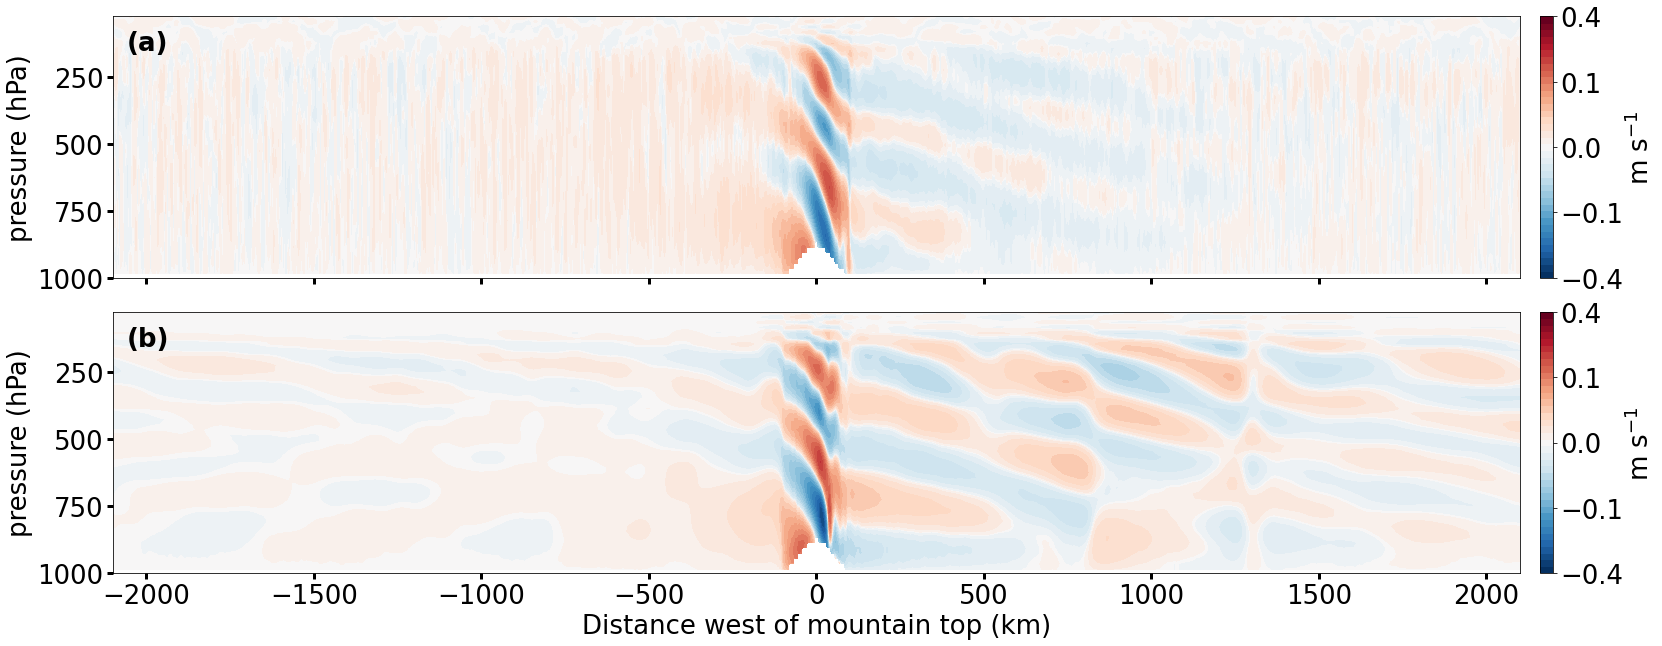

In [5]:
matplotlib.rcParams.update({'font.size': 26})
def levs(wmax,n):
    x=np.linspace(-wmax**(1/n),wmax**(1/n),40)
    return np.sign(x)*np.abs(x)**n

fig,ax=plt.subplots(2,1,figsize=(25,9))
wlevs=levs(0.4,2)
wticks=[-.5,-.4,-.1,0.,.1,.4,.5]

wmean_p.plot.contourf(ax=ax[0],yincrease=False, levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':r'm s$^{-1}$','pad':.012})#,cmap=plt.cm.RdBu)
wdrymean_p.plot.contourf(ax=ax[1],yincrease=False, levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':r'm s$^{-1}$','pad':.012})

for a in ax:
    a.set_ylabel("pressure (hPa)")
    a.set_xlim(-2100,2100)
    a.set_yticks([250,500,750,1000])
    a.tick_params(width=3,length=6)
    
ticks=range(-2000,2100,500)
ax[0].set_xticks(ticks)
ax[0].set_xticklabels([""]*len(ticks))
ax[0].set_xlabel("")
ax[1].set_xlabel("Distance west of mountain top (km)")

ax[0].text(0.01, 0.87,'(a)', transform=ax[0].transAxes,color='k',weight='bold')
ax[1].text(0.01, 0.87,'(b)', transform=ax[1].transAxes,color='k',weight='bold')

fig.tight_layout(pad=0.3)
#fig.savefig('figures/wxz.png', dpi=300 ,bbox_inches='tight')


# Figure 5 - x-y cross section of vertical motion at 500hPa

In [8]:
w_day152=xr.open_dataarray("data/wrf.100x2.mountain.3km.W_PL.day138.500hPa.nc")

Text(0.5, 1.0, '')

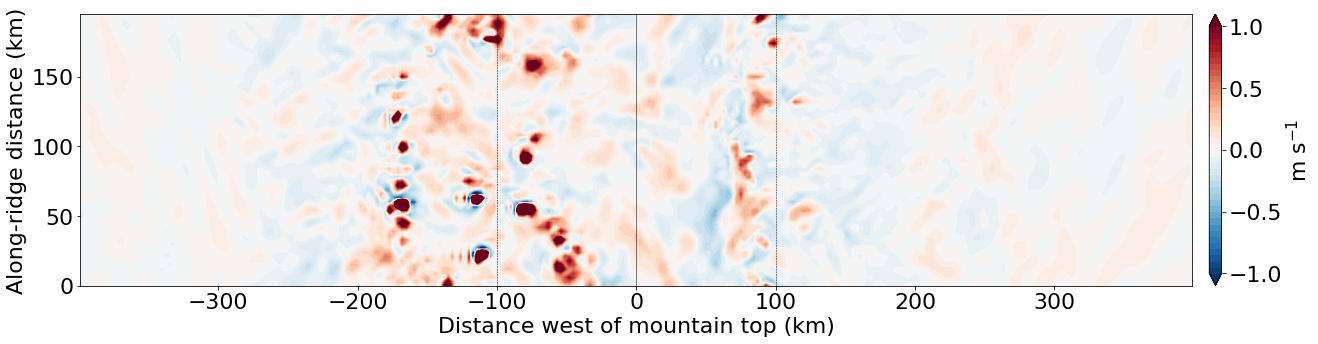

In [9]:
matplotlib.rcParams.update({'font.size': 22})
fig,ax = plt.subplots(1,1,figsize=(25,5))

wscale=1.
wlevs=np.linspace(-wscale,wscale,41)
wticks=np.arange(-1.5,1.6,0.5)

ax.axvline(   0.,color='k',linewidth=0.5)
ax.axvline(-100.,color='k',linewidth=0.5,linestyle='--')
ax.axvline( 100.,color='k',linewidth=0.5,linestyle='--')
w_day152.plot.contourf(ax=ax,levels=wlevs,cbar_kwargs={'ticks':wticks,'label':r'm s$^{-1}$','pad':.012})
ax.set_aspect("equal")
ax.set_xlabel("Distance west of mountain top (km)")
ax.set_ylabel("Along-ridge distance (km)")
ax.set_title("")
#fig.savefig('figures/wxy.eps',bbox_inches='tight')

# Figure 6 - Thermo equation breakdown

In [4]:
umean_p     = xr.open_dataarray("data/wrf.100x2.mountain.3km.U_PL.days50-200.mean.nc")
tmean_p     = xr.open_dataarray("data/wrf.100x2.mountain.3km.T_PL.days50-200.mean.nc")
omegamean_p = xr.open_dataarray("data/wrf.100x2.mountain.3km.OMEGA_PL.days50-200.mean.nc")
thetamean_p = xr.open_dataarray("data/wrf.100x2.mountain.3km.THETA_PL.days50-200.mean.nc")

dryumean_p     = xr.open_dataarray("data/wrf.100x2.mountain.dry.3km.U_PL.days50-100.mean.nc")
drytmean_p     = xr.open_dataarray("data/wrf.100x2.mountain.dry.3km.T_PL.days50-100.mean.nc")
dryomegamean_p = xr.open_dataarray("data/wrf.100x2.mountain.dry.3km.OMEGA_PL.days50-100.mean.nc")
drythetamean_p = xr.open_dataarray("data/wrf.100x2.mountain.dry.3km.THETA_PL.days50-100.mean.nc")

plevs_875 = np.array(umean_p.pressure[::-1])
DeltaP=150-875

Qrad = -xr.open_dataarray("data/wrf.100x2.mountain.3km.radiativecooling.days50-200.mean.nc")/pT_ov_g/cp*86400 #Convert W/m2 into K/day

In [5]:
pi = (drytmean_p.pressure/1e3)**0.286
dryudtdx = -(dryumean_p*drytmean_p.differentiate('distance_from_mtn')/1000 * 86400).integrate('pressure')/DeltaP
dryomegadsdp = (pi*dryomegamean_p*drythetamean_p.differentiate('pressure')/100 * 86400).integrate('pressure')/DeltaP

udtdx = -(umean_p*tmean_p.differentiate('distance_from_mtn')/1000 * 86400).integrate('pressure')/DeltaP
omegadsdp = (pi*omegamean_p*thetamean_p.differentiate('pressure')/100 * 86400).integrate('pressure')/DeltaP
Qdiab = udtdx+omegadsdp- Qrad

In [6]:
dryu0dtdx = -(-10*drytmean_p.differentiate('distance_from_mtn')/1000 * 86400).integrate('pressure')/DeltaP
dryomegads0dp = (pi*dryomegamean_p*drythetamean_p[:,2200:3000].mean('distance_from_mtn').differentiate('pressure')/100 * 86400).integrate('pressure')/DeltaP

u0dtdx = -(-10*tmean_p.differentiate('distance_from_mtn')/1000 * 86400).integrate('pressure')/DeltaP
omegads0dp = (pi*omegamean_p*thetamean_p[:,2200:3000].mean('distance_from_mtn').differentiate('pressure')/100 * 86400).integrate('pressure')/DeltaP
Qdiab_lin = u0dtdx+omegads0dp- Qrad

In [7]:
hrpr=xr.open_dataarray("data/wrf.100x2.mountain.3km.precip.days50-200.mean.nc")
hrpr_K = Lc/cp/(-DeltaP*100)*g*hrpr

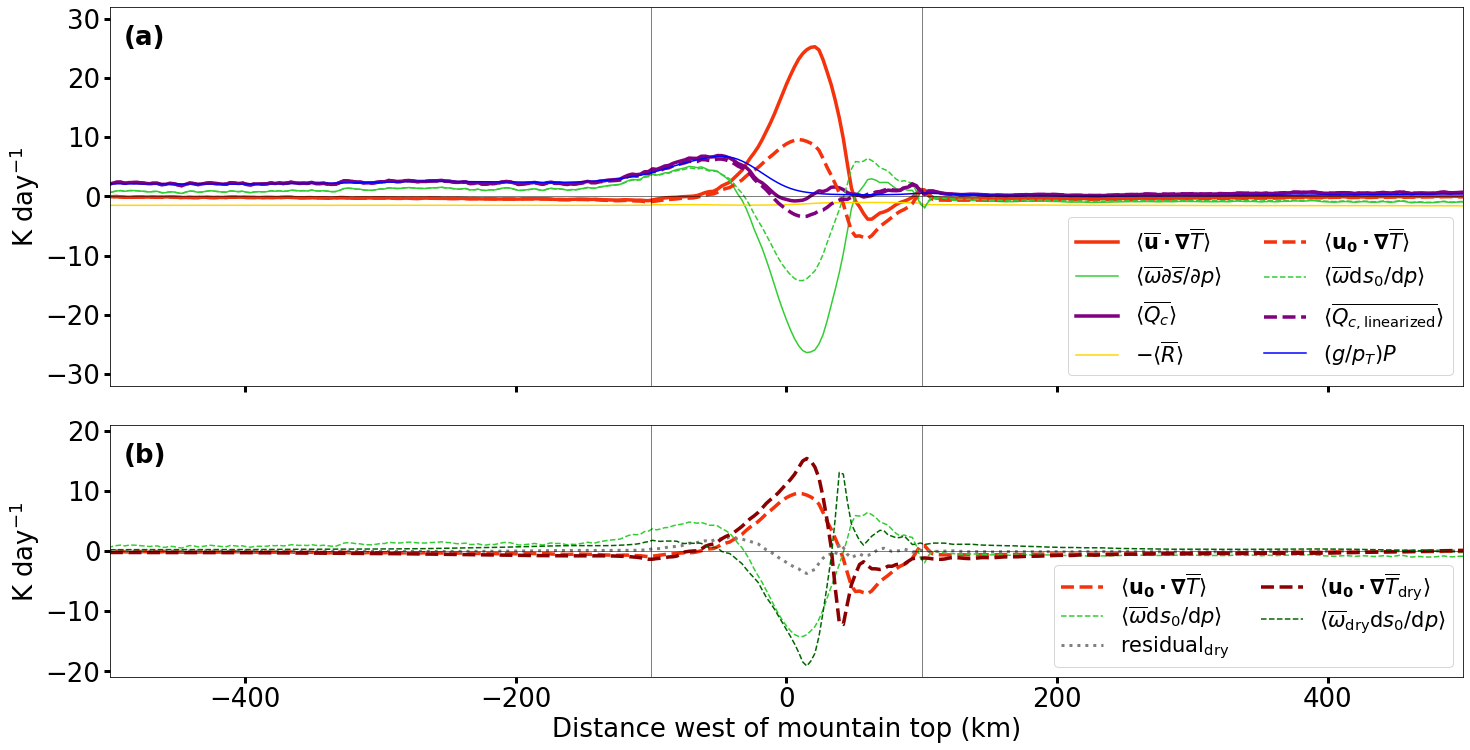

In [8]:
matplotlib.rcParams.update({'font.size': 26})

fig = plt.figure(figsize=(21,11))
spec = gridspec.GridSpec(ncols=1, nrows=2, height_ratios= [3,2],figure=fig)
ax  = fig.add_subplot(spec[0])
ax2 = fig.add_subplot(spec[1])
lw1=3.5
lw2=1.5

# First panel
ax.plot(hrdist, udtdx     ,linewidth=lw1,label=r"$\langle \mathbf{\overline{u} \cdot \nabla } \overline{T} \rangle$",color="xkcd:vermillion",linestyle='-')
ax.plot(hrdist, omegadsdp ,linewidth=lw2,label=r"$\langle \overline{\omega} \partial\overline{s}/\partial p\rangle$",color="limegreen"          ,linestyle='-')
ax.plot(hrdist, Qdiab     ,linewidth=lw1,label=r"$\langle \overline{Q_c}                                   \rangle$", color="purple"        ,linestyle='-')
ax.plot(hrdist, Qrad      ,linewidth=lw2,label=r"$-\langle \overline{R}                                    \rangle$", color='gold'        )

ax.plot(hrdist, u0dtdx    ,linewidth=lw1,label=r"$\langle\mathbf{u_0 \cdot \nabla } \overline{T}     \rangle$",color="xkcd:vermillion",linestyle='--')
ax.plot(hrdist, omegads0dp,linewidth=lw2,label=r"$\langle\overline{\omega} \mathrm{d}s_0/\mathrm{d}p \rangle$",color="limegreen"      ,linestyle='--')
ax.plot(hrdist, Qdiab_lin ,linewidth=lw1,label=r"$\langle\overline{Q_{c,\mathrm{linearized}}}        \rangle$",color="purple"         ,linestyle='--')
ax.plot(hrdist, hrpr_K      ,linewidth=lw2,label=r"$(g/p_T)P$", color='b')

# Second panel
ax2.plot(hrdist, u0dtdx      ,linewidth=lw1,label=r"$\langle\mathbf{u_0 \cdot \nabla } \overline{T}    \rangle$",color="xkcd:vermillion",linestyle='--')
ax2.plot(hrdist, omegads0dp  ,linewidth=lw2,label=r"$\langle\overline{\omega} \mathrm{d}s_0/\mathrm{d}p\rangle$",color="limegreen"      ,linestyle='--')
ax2.plot(hrdist, dryu0dtdx +dryomegads0dp   ,linewidth=3,label=r"residual$_\mathrm{dry}$",color="grey" ,linestyle=':')

ax2.plot(hrdist, dryu0dtdx    ,linewidth=lw1,label=r"$\langle\mathbf{u_0 \cdot \nabla } \overline{T}_\mathrm{dry}     \rangle$",color="darkred" ,linestyle='--')
ax2.plot(hrdist, dryomegads0dp,linewidth=lw2,label=r"$\langle\overline{\omega}_\mathrm{dry} \mathrm{d}s_0/\mathrm{d}p \rangle$",color="darkgreen"   ,linestyle='--')

#Decoration
for a in ax,ax2:
    a.axvline(-100.,color='k',linewidth=0.5)
    a.axvline(100.,color='k',linewidth=0.5)
    a.axhline(0.,color='k',linewidth=0.5)
    a.set_xlim(-500,500)
    a.set_ylabel(r"K day$^{-1}$")
    a.tick_params(width=3,length=6)
ax.legend(ncol=2,loc=4,fontsize=21)
ax2.legend(ncol=2,loc=4,fontsize=21,labelspacing=0.2,borderpad=0.3,columnspacing=1.5)
ax.set_ylim(-32,32)
ax2.set_ylim(-21,21)
ax2.set_xlabel("Distance west of mountain top (km)")
ax.text(0.01, 0.9,'(a)', transform=ax.transAxes,color='k',weight='bold')
ax2.text(0.01, 0.85,'(b)', transform=ax2.transAxes,color='k',weight='bold')

ticks=range(-400,500,200)
ax.set_xticks(ticks)
ax.set_xticklabels([""]*len(ticks))
ax2.set_yticks(range(-20,21,10))

fig.tight_layout()
#fig.savefig('figures/thermoeqn.eps',bbox_inches='tight')

# Figure 7 - $\hat T_d$ and $\hat q_d$

In [4]:
tmean_p    = xr.open_dataarray("data/wrf.100x2.mountain.3km.T_PL.days50-200.mean.nc")
drytmean_p = xr.open_dataarray("data/wrf.100x2.mountain.dry.3km.T_PL.days50-100.mean.nc")
qmean_p    = xr.open_dataarray("data/wrf.100x2.mountain.3km.Q_PL.days50-200.mean.nc")
dryqmean_p = xr.open_dataarray("data/wrf.100x2.mountain.dry.3km.Q_PL.days50-100.mean.nc")
hrpr       = xr.open_dataarray("data/wrf.100x2.mountain.3km.precip.days50-200.mean.nc")
thetae     = xr.open_dataarray("data/wrf.100x2.mountain.3km.THETAE.days50-200.mean.nc")                     

In [5]:
tmean_p_hat_prime         = hatprime(tmean_p,0,7)
drytmean_p_hat_prime      = hatprime(drytmean_p,0,7)

qmean_p_hat_prime         = Lc/cp*hatprime(qmean_p,0,7)    # convert to K
dryqmean_p_hat_prime      = Lc/cp*hatprime(dryqmean_p,0,7) # convert to K

xx,hx = topographic_profile(kind='cos',a=100e3,A=1000)
Td_hat_linear,qd_hat_linear = linear_TdL_qdL(xx,hx,10)  #Predictions of the linear theory; see orographicConvectionTheory.py

In [6]:
#Average Theta_e over BL and take deviation from upstream
thetae_bl = thetae[:3].mean("bottom_top")
thetae_bl_prime = thetae_bl - thetae_bl[2200:2400].mean('west_east')

#Compute Theta_e*, average over lower troposphere and take deviation from upstream
import metpy.calc as mpcalc
from metpy.units import units
zero_array = 0.*tmean_p[:7]
pressure_broadcasted = zero_array+tmean_p[:7].pressure
thetaestar_L_alllevs =  np.array(mpcalc.saturation_equivalent_potential_temperature(np.array(pressure_broadcasted)*units.hPa,
                                                                                    np.array(tmean_p[:7])*units.K
                                                                                   )/ units.K)
thetaestar_L = (zero_array + thetaestar_L_alllevs).mean('pressure') #Convert to xarray DataArray, average in vertical
thetaestar_L_prime = thetaestar_L - thetaestar_L[2200:2400].mean('distance_from_mtn')

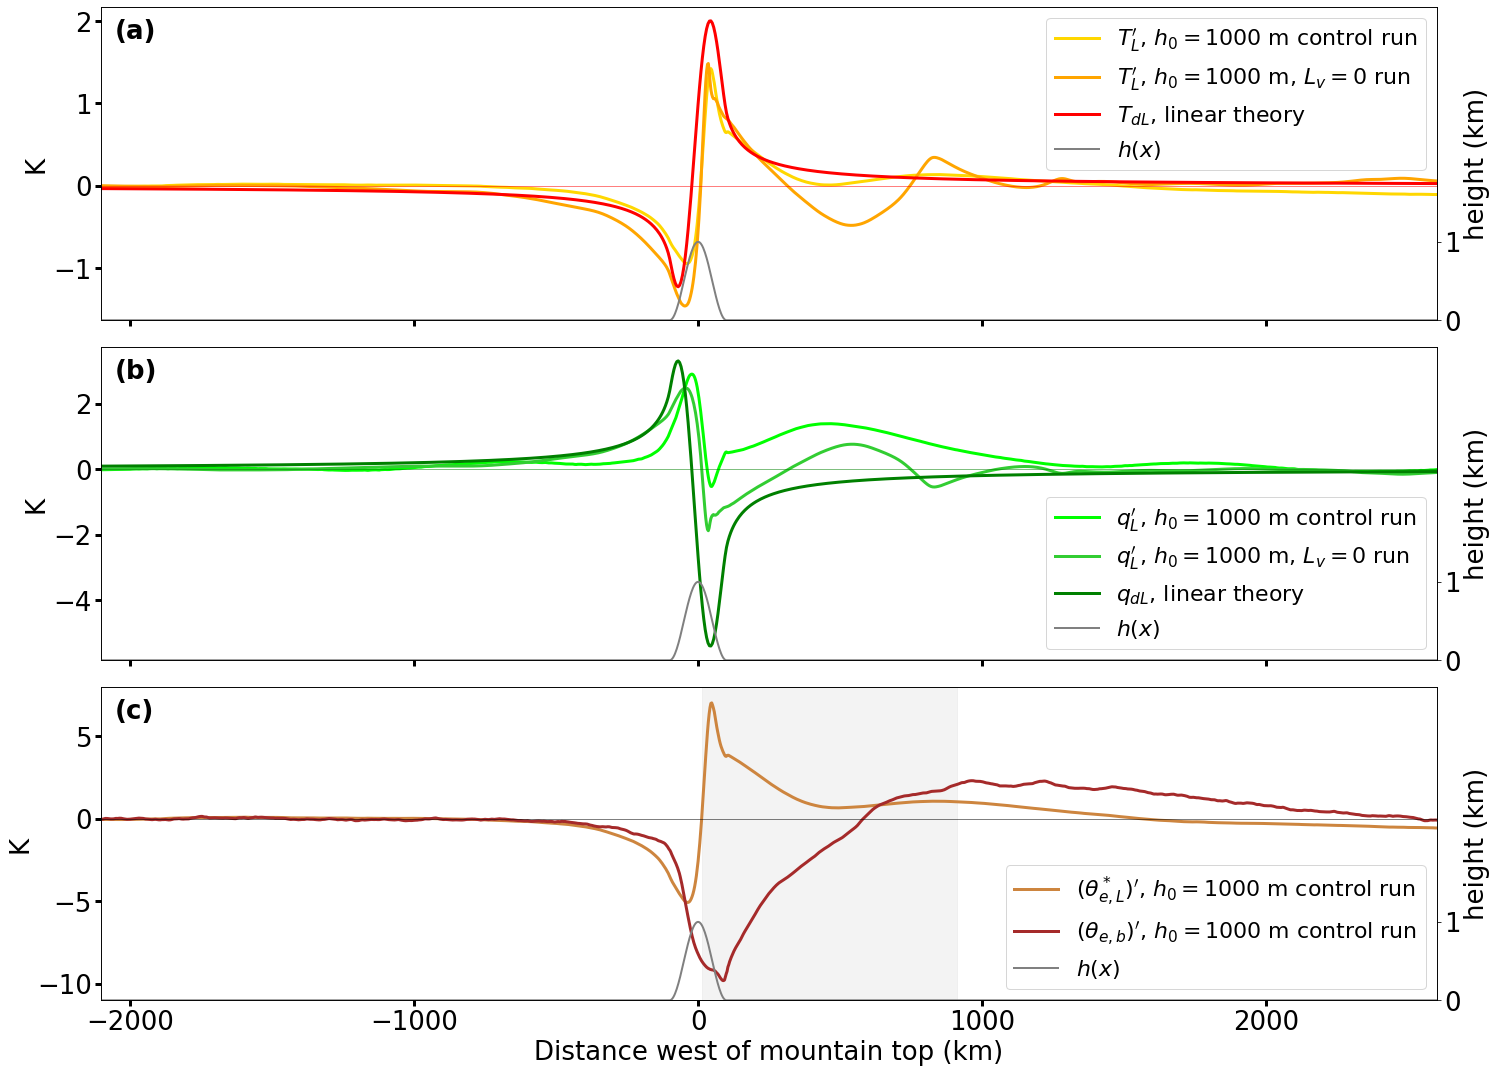

In [7]:
matplotlib.rcParams.update({'font.size': 26})
fig,(ax,ax2,ax3) = plt.subplots(3,1,figsize=(21,15))
axm=ax.twinx()
ax2m=ax2.twinx()
ax3m=ax3.twinx()

# Panel a : temperature deviations
tmean_p_hat_prime.plot(   ax=ax,color='gold'  ,linewidth=3,label=r"$T_L'$, $h_0=1000$ m control run")
drytmean_p_hat_prime.plot(ax=ax,color='orange',linewidth=3,label=r"$T_L'$, $h_0=1000$ m, $L_v=0$ run")
ax.plot(xx/1000,Td_hat_linear,   color='red'   ,linewidth=3,label=r"$T_{dL}$, linear theory")
ax.axhline(0.,linestyle='-',linewidth='0.5',color='red')

# Panel b : moisture deviations
qmean_p_hat_prime.plot(   ax=ax2,color='lime'     ,linewidth=3,label=r"$q_L'$, $h_0=1000$ m control run")
dryqmean_p_hat_prime.plot(ax=ax2,color='limegreen',linewidth=3,label=r"$q_L'$, $h_0=1000$ m, $L_v=0$ run")
ax2.plot(xx/1000,qd_hat_linear,   color='green'    ,linewidth=3,label=r"$q_{dL}$, linear theory")
ax2.axhline(0.,linestyle='-',linewidth='0.5',color='green')

# Panel c - QE test
ax3.plot(hrdist,thetaestar_L_prime,label=r"$(\theta_{e,L}^*)'$, $h_0=1000$ m control run",color='peru',linewidth=3)
ax3.plot(hrdist,thetae_bl_prime   ,label=r"$(\theta_{e,b})'$, $h_0=1000$ m control run" ,color='brown',linewidth=3)
ax3.fill_between(hrdist,-15,15,where=hrpr<2.1,color='lightgrey',alpha=0.25)

#Decoration
ax3.axhline(0.,color='k',linestyle='-',linewidth=0.5)
ax3.set_ylim(-11,8)

for a,am,loc,txt in (ax,axm,0,'(a)'),(ax2,ax2m,4,'(b)'),(ax3,ax3m,4,'(c)'):
    a.set_xlim(-2100,2600)
    a.set_ylabel("K")
    a.legend(fontsize=20)
    
    am.plot(hrdist,hrhgt/1000,label=r"$h(x)$",color='gray',linewidth=2)
    am.set_ylabel('height (km)')
    am.set_ylim(0,4)
    am.set_yticks([0,1])
    ticks=range(-2000,3000,1000)
    a.set_xticks(ticks)
    a.tick_params(width=3,length=6)
    
    lines, labels = a.get_legend_handles_labels()
    lines2, labels2 = am.get_legend_handles_labels()
    a.legend(lines + lines2, labels + labels2,fontsize=22,loc=loc)
    
    a.text(0.01, 0.9,txt, transform=a.transAxes,color='k',weight='bold')
    
    if txt == '(c)':
        a.set_xlabel('Distance west of mountain top (km)')
    else:
        a.set_xticklabels([""]*len(ticks))
        a.set_xlabel('')

fig.tight_layout(pad=0.4)
#fig.savefig('figures/TLqL.eps',bbox_inches='tight')

# Figure 8 - Unfitted and fitted precip

In [4]:
tmean_p    = xr.open_dataarray("data/wrf.100x2.mountain.3km.T_PL.days50-200.mean.nc")
lmtmean_p  = xr.open_dataarray("data/wrf.100x2.mountain.500m.3km.T_PL.days50-200.mean.nc")
dryqmean_p = xr.open_dataarray("data/wrf.100x2.mountain.dry.3km.Q_PL.days50-100.mean.nc")
tmean_p_hat_prime         = hatprime(tmean_p,0,7)
lmtmean_p_hat_prime = hatprime(lmtmean_p,0,7)
dryqmean_p_hat_prime      = Lc/cp*hatprime(dryqmean_p,0,7) # convert to K


In [5]:
%%time
hrpr=xr.open_dataarray("data/wrf.100x2.mountain.3km.precip.days50-200.mean.nc")
lmpr=xr.open_dataarray("data/wrf.100x2.mountain.500m.3km.precip.days50-200.mean.nc")

xx,hx = topographic_profile(kind='cos',a=100e3,A=1000)
Plin        = linear_precip_theory(xx,hx,  10)
Plin_fit    = linear_precip_theory(xx,hx,  10,tauT=7.5,tauq=27.5)
lmPlin_fit = linear_precip_theory(xx,hx/2,10,tauT=7.5,tauq=27.5)

Pnonlin       = nonlinear_precip_theory(1000*hrdist[::-1],np.array(tmean_p_hat_prime)[::-1],np.array(dryqmean_p_hat_prime)[::-1],10)[::-1] #wrf data are sorted west to east, we need to flip them before inputting to the nonlinear precip theory
Pnonlin_fit   = nonlinear_precip_theory(1000*hrdist[::-1],np.array(tmean_p_hat_prime)[::-1],np.array(dryqmean_p_hat_prime)[::-1],10,tauT=7.5,tauq=27.5)[::-1] 
lmPnonlin_fit = nonlinear_precip_theory(1000*hrdist[::-1],np.array(lmtmean_p_hat_prime)[::-1],np.array(dryqmean_p_hat_prime)[::-1]/2,10,tauT=7.5,tauq=27.5)[::-1] 

CPU times: user 15.5 s, sys: 7.12 ms, total: 15.5 s
Wall time: 15.5 s


In [6]:
xx2,_,Plin_smith = smith_theory(xx,hx,10,5e-3,4.32e-3)

using dry stability, N=0.013 s^-1


Text(0.01, 0.9, '(c)')

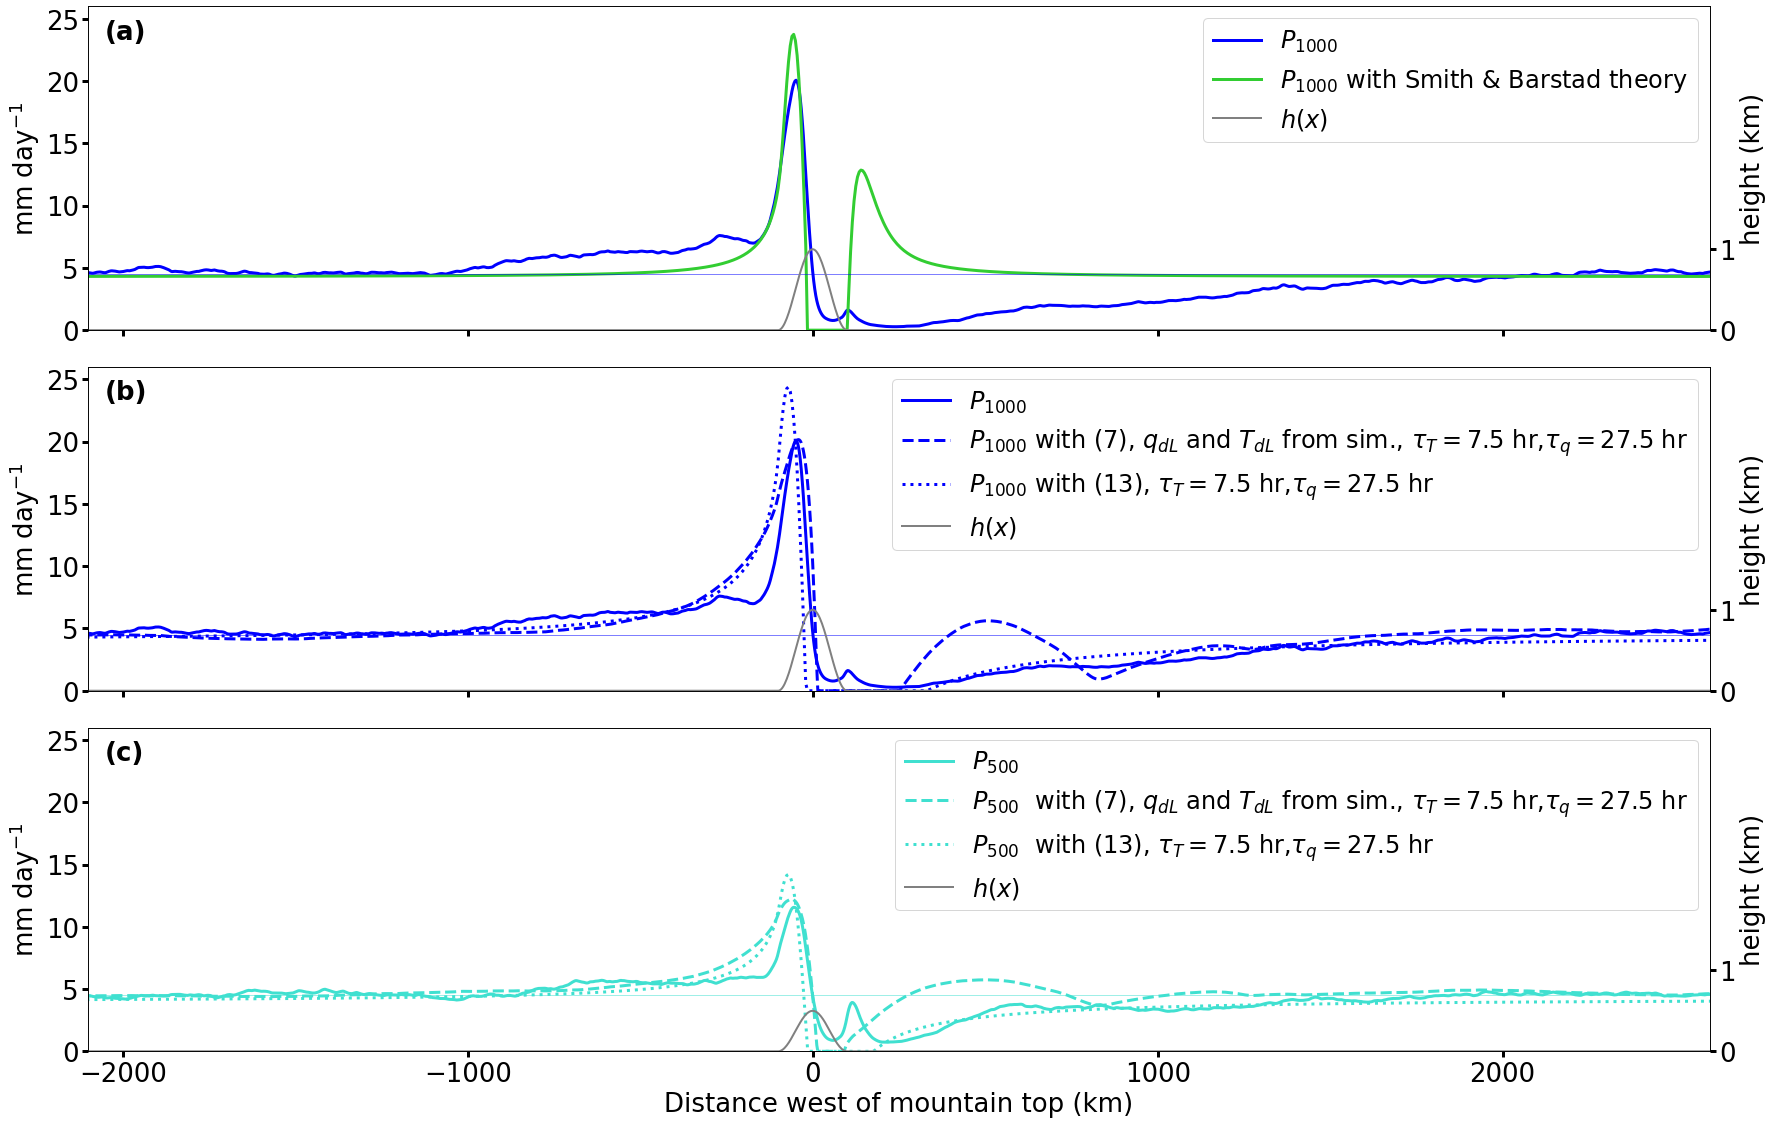

In [7]:
matplotlib.rcParams.update({'font.size': 26})
fig,(ax,ax2,ax3)=plt.subplots(3,1,figsize=(25,16))
axm=ax.twinx()
axm2=ax2.twinx()
axm3=ax3.twinx()

lw=3

# Top panel
ax.plot(hrdist,hrpr,    label=r"$P_{1000}$",color='b',linewidth=lw)
ax.plot(xx2/1000,((Plin_smith-4.5)/2.5+4.5)*(Plin_smith>0), label=r"$P_{1000}$ with Smith & Barstad theory",color='limegreen',linestyle='-',linewidth=lw)

## Middle panel
ax2.plot(hrdist,hrpr,        label=r"$P_{1000}$",color='b',linewidth=lw)
ax2.plot(hrdist,Pnonlin_fit, label=r"$P_{1000}$ with (7), $q_{dL}$ and $T_{dL}$ from sim., $\tau_T=7.5$ hr,$\tau_q=27.5$ hr",color='b',linestyle='--',linewidth=lw)
ax2.plot(xx/1000,Plin_fit,    label=r"$P_{1000}$ with (13), $\tau_T=7.5$ hr,$\tau_q=27.5$ hr",color='b',linestyle=':',linewidth=lw)

## Bottom panel
ax3.plot(hrdist,lmpr,          label=r"$P_{500}$",color='turquoise',linewidth=lw)
ax3.plot(hrdist,lmPnonlin_fit, label=r"$P_{500}$  with (7), $q_{dL}$ and $T_{dL}$ from sim., $\tau_T=7.5$ hr,$\tau_q=27.5$ hr",color='turquoise',linestyle='--',linewidth=lw)
ax3.plot(xx/1000,lmPlin_fit,   label=r"$P_{500}$  with (13), $\tau_T=7.5$ hr,$\tau_q=27.5$ hr",color='turquoise',linestyle=':',linewidth=lw)

#Decoration
ax.set_ylim(0,26)
ax2.set_ylim(0,26)
ax3.set_ylim(0,26)

for i,(a,am) in enumerate(zip((ax,ax2,ax3),(axm,axm2,axm3))):
    a.set_ylabel(r'mm day$^{-1}$')
    a.set_xlim(-2.1e3,2.6e3)
    a.tick_params(width=3,length=6)
    am.tick_params(width=3,length=6)
    
    if i==2:
        a.set_xlabel('Distance west of mountain top (km)')
        a.axhline(4.5,linestyle='-',linewidth=0.5,color='turquoise')
        am.plot(hrdist,hrhgt/1000/2,label=r"$h(x)$",color='gray',linewidth=2)
    else:
        ticks=range(-2000,3000,1000)
        a.set_xticks(ticks)
        a.set_xticklabels([""]*len(ticks))
        a.axhline(4.5,linestyle='-',linewidth=0.5,color='b')
        am.plot(hrdist,hrhgt/1000,label=r"$h(x)$",color='gray',linewidth=2)
    
    am.set_ylabel('height (km)')
    am.set_ylim(0,4)
    am.set_yticks([0,1])
    
    lines, labels = a.get_legend_handles_labels()
    lines2, labels2 = am.get_legend_handles_labels()
    a.legend(lines + lines2, labels + labels2, loc=1,fontsize=24)
fig.tight_layout(pad=0.8)
ax.text(0.01, 0.9,'(a)', transform=ax.transAxes,color='k',weight='bold')
ax2.text(0.01, 0.9,'(b)', transform=ax2.transAxes,color='k',weight='bold')
ax3.text(0.01, 0.9,'(c)', transform=ax3.transAxes,color='k',weight='bold')

#fig.savefig('figures/Pcompare.eps',bbox_inches='tight')

# Figure 9 - evaporation and radiative cooling profiles

In [4]:
hrhfx  = xr.open_dataarray("data/wrf.100x2.mountain.3km.HFX.days50-200.mean.nc")
hrradc = xr.open_dataarray("data/wrf.100x2.mountain.3km.radiativecooling.days50-200.mean.nc")
hrevap = xr.open_dataarray("data/wrf.100x2.mountain.3km.QFX.days50-200.mean.nc")
lmradc = xr.open_dataarray("data/wrf.100x2.mountain.500m.3km.radiativecooling.days50-200.mean.nc")
lmevap = xr.open_dataarray("data/wrf.100x2.mountain.500m.3km.QFX.days50-200.mean.nc")

In [5]:
tmean_p    = xr.open_dataarray("data/wrf.100x2.mountain.3km.T_PL.days50-200.mean.nc")
lmtmean_p  = xr.open_dataarray("data/wrf.100x2.mountain.500m.3km.T_PL.days50-200.mean.nc")
dryqmean_p = xr.open_dataarray("data/wrf.100x2.mountain.dry.3km.Q_PL.days50-100.mean.nc")
tmean_p_hat_prime         = hatprime(tmean_p,0,7)
lmtmean_p_hat_prime = hatprime(lmtmean_p,0,7)
dryqmean_p_hat_prime      = Lc/cp*hatprime(dryqmean_p,0,7) # convert to K


In [6]:
#%%time
#Compute alpha, the relative deviation in P_0, defined such that P_0(x) = constantP0(1+alpha(x)). See definition of P_0 in eqn (5)
Ms = 2370
Mh = 455
Mq = Ms-Mh

hrevap_prime = hrevap/hrevap[2000:3000].mean() - 1
hrradc_prime = hrradc/hrradc[2000:3000].mean() - 1
hralpha_evap_rad = np.array((Ms*hrevap_prime-Mq*hrradc_prime)/Mh)[::-1]

Ms = 2341
Mh = 450
Mq = Ms-Mh

lmevap_prime = lmevap/lmevap[2000:3000].mean() - 1
lmradc_prime = lmradc/lmradc[2000:3000].mean() - 1
lmalpha_evap_rad = np.array((Ms*lmevap_prime-Mq*lmradc_prime)/Mh)[::-1]

#Precip predicted by nonlinear theory with adapted evap&radiative cooling
Pnonlin_e   = nonlinear_precip_theory(1000*hrdist[::-1],np.array(tmean_p_hat_prime)[::-1  ],np.array(dryqmean_p_hat_prime)[::-1]  ,10,tauT=7.5,tauq=27.5,P0=4.5,alpha=hralpha_evap_rad)[::-1]
lmPnonlin_e = nonlinear_precip_theory(1000*hrdist[::-1],np.array(lmtmean_p_hat_prime)[::-1],np.array(dryqmean_p_hat_prime)[::-1]/2,10,tauT=7.5,tauq=27.5,P0=4.5,alpha=lmalpha_evap_rad)[::-1]

hrpr=xr.open_dataarray("data/wrf.100x2.mountain.3km.precip.days50-200.mean.nc")
lmpr=xr.open_dataarray("data/wrf.100x2.mountain.500m.3km.precip.days50-200.mean.nc")

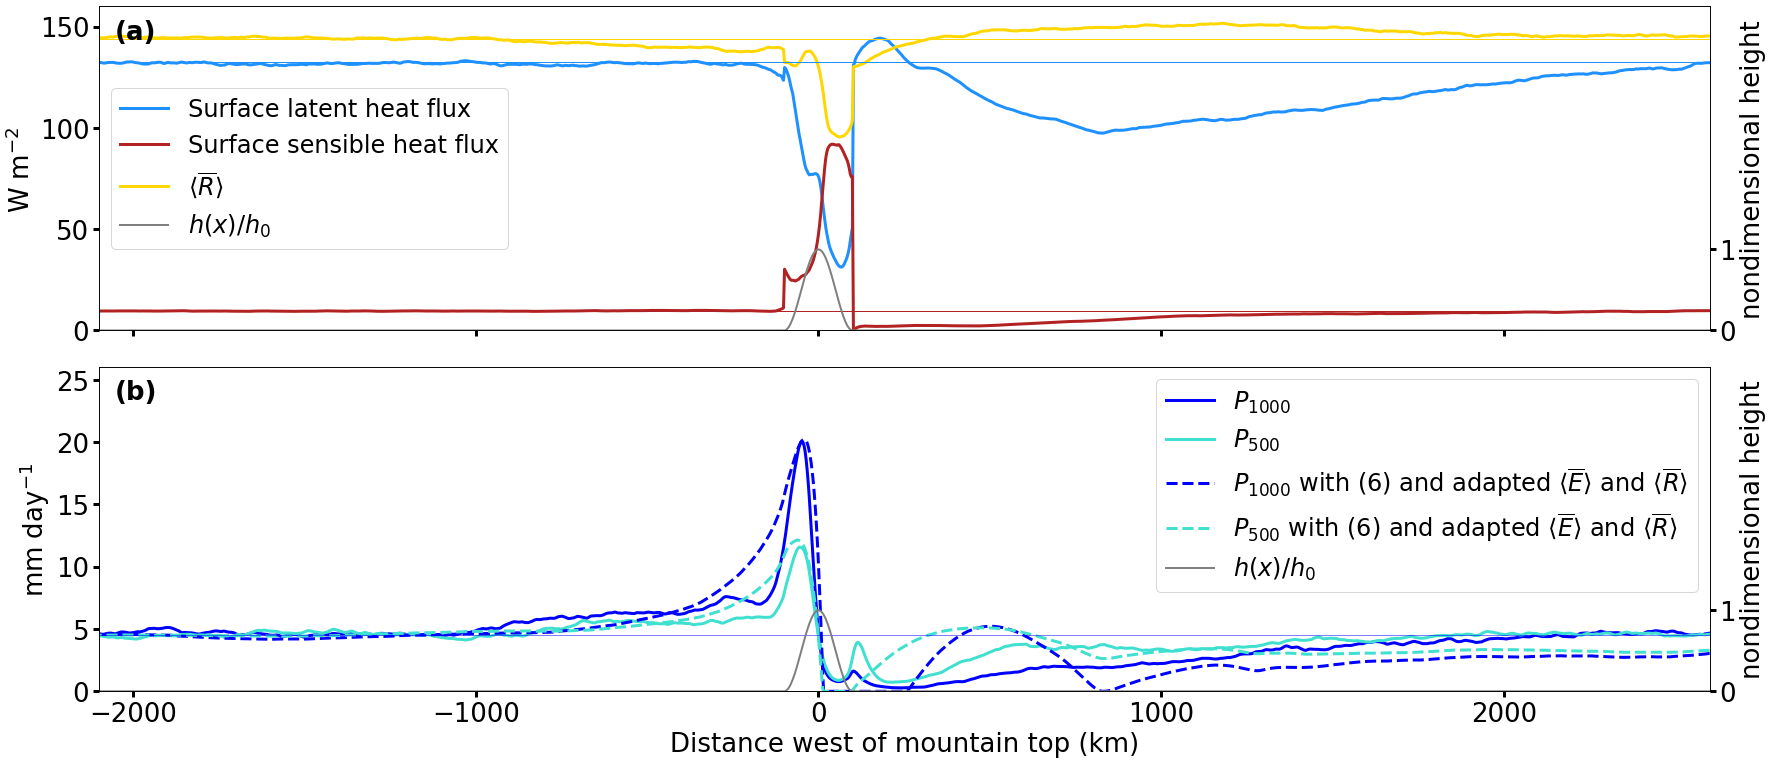

In [7]:
matplotlib.rcParams.update({'font.size': 26})
fig,(ax,ax2)=plt.subplots(2,1,figsize=(25,11))
axm=ax.twinx()
axm2=ax2.twinx()

lw=3
lwl=1

## Top panel - fluxes
ax.plot(hrdist,Lc*hrevap, label=r"Surface latent heat flux",color='dodgerblue',linewidth=lw)
ax.plot(hrdist,hrhfx, label=r"Surface sensible heat flux",color='firebrick',linewidth=lw)
ax.plot(hrdist,hrradc, label=r"$\langle\overline{R}\rangle$",color='gold',linewidth=lw)
ax.axhline(Lc*hrevap[2200:3000].mean(),linestyle='-',linewidth=lwl,color='dodgerblue')
ax.axhline(hrhfx[2200:3000].mean(),linestyle='-',linewidth=lwl,color='firebrick')
ax.axhline(hrradc[2200:3000].mean(),linestyle='-',linewidth=lwl,color='gold')
ax.set_ylabel(r'W m$^{-2}$')
ax.set_ylim(0,160)

## Bottom panel - precip & fits
ax2.plot(hrdist,hrpr,       label=r"$P_{1000}$",color='b',linewidth=lw)
ax2.plot(hrdist,lmpr,       label=r"$P_{500}$",color='turquoise',linewidth=lw)
ax2.plot(hrdist,Pnonlin_e  ,label=r"$P_{1000}$ with (6) and adapted $\langle\overline{E}\rangle$ and $\langle\overline{R}\rangle$",color='b',linestyle='--',linewidth=lw)
ax2.plot(hrdist,lmPnonlin_e,label=r"$P_{500}$ with (6) and adapted $\langle\overline{E}\rangle$ and $\langle\overline{R}\rangle$",color='turquoise',linestyle='--',linewidth=lw)

#Decoration
ax2.axhline(4.5,linestyle='-',linewidth=0.5,color='b')
ax2.set_ylabel(r'mm day$^{-1}$')
ax2.set_ylim(0,26)

for i,(a,am) in enumerate(zip((ax,ax2),(axm,axm2))):
    am.plot(hrdist,hrhgt/1000,label=r"$h(x)/h_0$",color='gray',linewidth=2)
    
    a.set_xlim(-2.1e3,2.6e3)
    a.tick_params(width=3,length=6)
    am.tick_params(width=3,length=6)
    
    if i==1:
        a.set_xlabel('Distance west of mountain top (km)')
    else:
        ticks=range(-2000,3000,1000)
        a.set_xticks(ticks)
        a.set_xticklabels([""]*len(ticks))
    
    am.set_ylabel('nondimensional height')
    am.set_ylim(0,4)
    am.set_yticks([0,1])
    
    lines, labels = a.get_legend_handles_labels()
    lines2, labels2 = am.get_legend_handles_labels()
    a.legend(lines + lines2, labels + labels2, loc=0,fontsize=24)
    
ax.text(0.01, 0.9,'(a)', transform=ax.transAxes,color='k',weight='bold')
ax2.text(0.01, 0.9,'(b)', transform=ax2.transAxes,color='k',weight='bold')

fig.tight_layout(pad=0.8)
#fig.savefig('figures/evaprad.eps',bbox_inches='tight')

# Figure B1 - hovmoeller diagram of precipitation

In [10]:
hrpr_hovmoller_all = xr.open_dataarray("data/wrf.100x2.mountain.3km.precip.days50-200.hourly_meridionalmean.nc")

In [ ]:
#%%time 
## takes 6 min
#def select_hov_t(t0,t,d):
#    return ((t>=t0-.5+(d+4902)/36) & (t<=t0+.5+(d+4902)/36))
#
#n=len(hrpr_hovmoller_all.Time)-300
#p_characteristic=np.zeros(n)
#for t in range(n):
#    if t%25==0:
#        print(t,end=' ')
#    p_characteristic[t] = float(hrpr_hovmoller_all.where(select_hov_t(t,hrpr_hovmoller_all.Time,hrpr_hovmoller_all.distance_from_mtn))[t:t+300].mean())
#
#p_characteristic = xr.DataArray(p_characteristic,coords={'Time':hrpr_hovmoller_all.Time[:-300]},dims=['Time'])
#p_characteristic.to_netcdf("data/wrf.100x2.mountain.3km.precip_characteristiclines.days50-188.nc")

In [19]:
p_characteristic = xr.open_dataarray("data/wrf.100x2.mountain.3km.precip_characteristiclines.days50-188.nc")

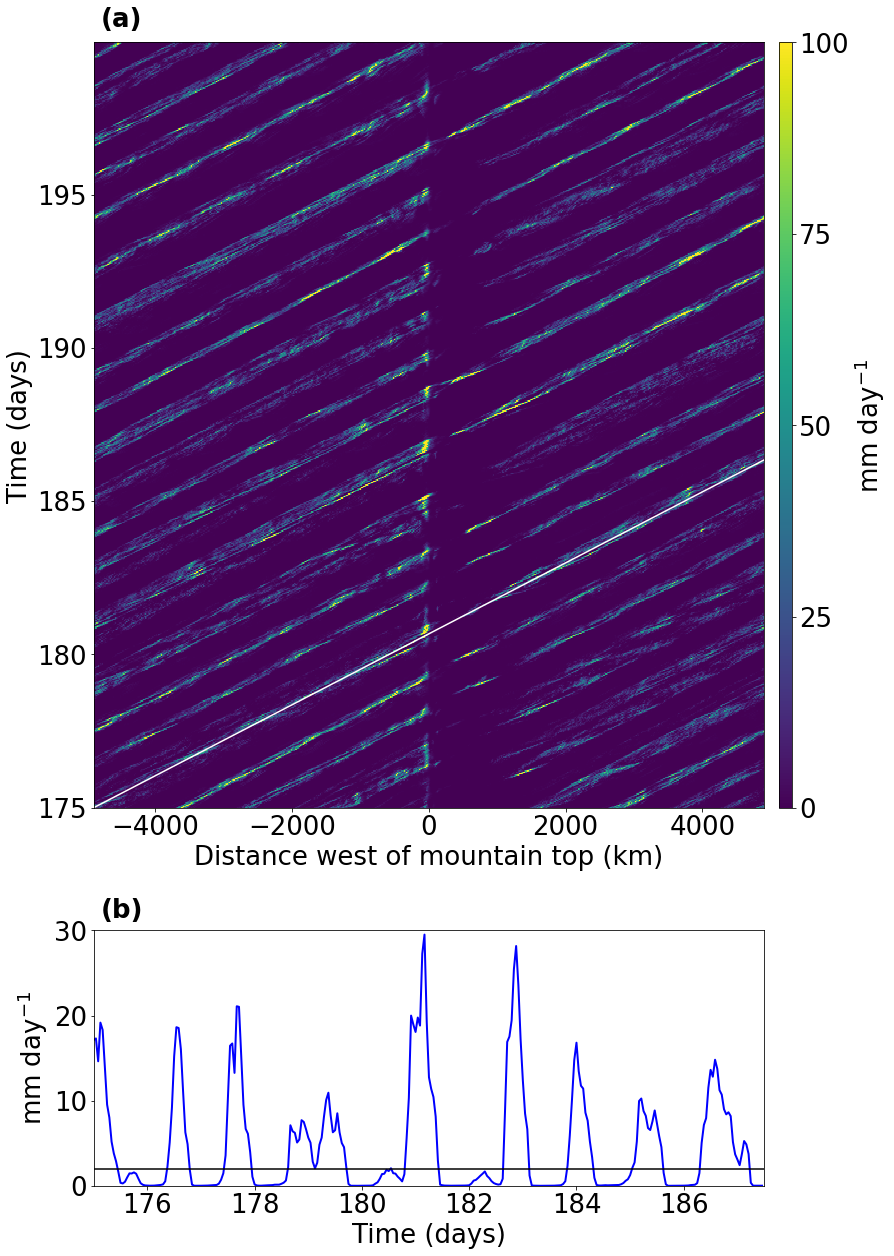

In [20]:
# Panels and layout
matplotlib.rcParams.update({'font.size': 26})
fig = plt.figure(figsize=(13,18))
spec = gridspec.GridSpec(ncols=1, nrows=2, height_ratios= [3,1],figure=fig)
ax = fig.add_subplot(spec[0])
ax2 = fig.add_subplot(spec[1])

#Top panel: hovemoeller diagram of precip
c=hrpr_hovmoller_all[-600:].plot(ax=ax,vmax=100,add_colorbar=False)#,cbar_kwargs={'pad':0.2,'label':r'mm day$^{-1}$'})
ax.plot(hrpr_hovmoller_all.distance_from_mtn,(hrpr_hovmoller_all.distance_from_mtn+4902)*1000/(10*3600),color='w')

#Top panel colorbar
pad=.2;size="2%"
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
plt.colorbar(c, cax=cax,label=r'mm day$^{-1}$',ticks=np.arange(0,101,25))

#Bottom panel: precip timeseries on characteristic lines
ax2.plot(p_characteristic[-300:], color='b',linewidth=2)
ax2.axhline(2.,color='k')

#Decoration
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
cax2.remove()

ax.set_xlabel('Distance west of mountain top (km)')
ax.set_ylabel('Time (days)')
ax.set_yticks(range(0,600,24*5))
ax.set_yticklabels(np.arange(0,600,24*5)//24+175)

ax2.set_ylabel(r'$t$')
ax2.set_ylabel(r'mm day$^{-1}$')

ax2.set_xlabel('Time (days)')
ax2.set_ylabel(r'mm day$^{-1}$')
ax2.set_xlim(0,300)
ax2.set_ylim(0,30)
ax2.set_xticks(range(24,300,24*2))
ax2.set_xticklabels(np.arange(24,300,24*2)//24+175)

ax.text(0.01, 1.02,'(a)', transform=ax.transAxes,color='k',weight='bold')
ax2.text(0.01, 1.05,'(b)', transform=ax2.transAxes,color='k',weight='bold')

fig.tight_layout()
#fig.savefig('figures/figB1.png', dpi=300 ,bbox_inches='tight')

# Figure B2 - Mean precipitation over rainy times only

In [4]:
hrpr=xr.open_dataarray("data/wrf.100x2.mountain.3km.precip.days50-200.mean.nc")
hrpr_hovmoller_all = xr.open_dataarray("data/wrf.100x2.mountain.3km.precip.days50-200.hourly_meridionalmean.nc")
p_characteristic = xr.open_dataarray("data/wrf.100x2.mountain.3km.precip_characteristiclines.days50-188.nc")

In [5]:
#Define timestamps where precip along characteristic line > 2mm/day
thresh_crossings=np.arange(len(p_characteristic)-1)[np.diff(p_characteristic>2)]
ends=thresh_crossings[1::2]+1
begs=thresh_crossings[::2][:len(ends)]

#Define function to select data points within those timestamps
from functools import reduce
def select_hov_all(t,d):
    return reduce(lambda x,y:x|y,[(t>=t1+(d+4902)/36) & (t<=t2+(d+4902)/36) for t1,t2 in zip(begs,ends)])

hrpr_rainy=hrpr_hovmoller_all.where(select_hov_all(hrpr_hovmoller_all.Time,hrpr_hovmoller_all.distance_from_mtn)).mean('Time')

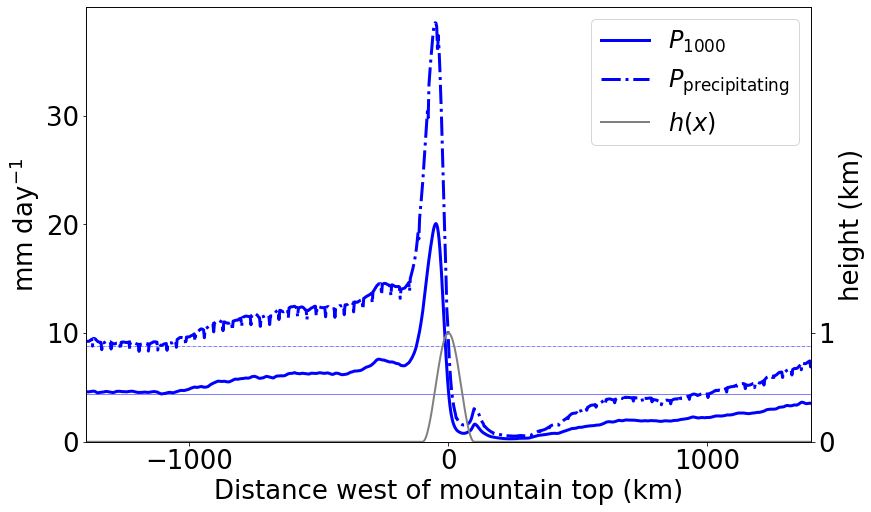

In [6]:
matplotlib.rcParams.update({'font.size': 26})

lw=3

fig,ax=plt.subplots(1,1,figsize=(13,8))
ax2=ax.twinx()

# precips
ax.plot(hrdist,hrpr,      label=r"$P_{1000}$",color='b',linewidth=lw)
ax.plot(hrdist,hrpr_rainy,label=r"$P_\mathrm{precipitating}$",color='b',linestyle='-.',linewidth=lw)

# mountain
ax2.plot(hrdist,hrhgt/1000,label=r"$h(x)$",color='gray',linewidth=2)

# decoration
ax.axhline(4.4,linestyle='-',linewidth=0.5,color='b')
ax.axhline(8.8,linestyle='-.',linewidth=0.5,color='b')
ax.set_xlabel('Distance west of mountain top (km)')
ax.set_ylabel(r'mm day$^{-1}$')
ax.set_xlim(-1.4e3,1.4e3)
ax.set_ylim(0,40)
ax.set_yticks(range(0,40,10))
ax.set_xticks(range(-1000,1001,1000))

ax2.set_ylabel('height (km)')
ax2.set_ylim(0,4)
ax2.set_yticks([0,1])

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc=0,fontsize=24)

#fig.savefig('figures/figB2.eps',bbox_inches='tight')